# Excercise project 3 with CNN time-series classification
## Step 0: Importing the necessary libraries

In [1]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

## Step 1: Reading the dataset
In this exercise, I selected an Ethereum dataset. Each entry provides information on the daily ETH-USD exchange rate with the trading volume for that day. For the classification task, I’ll be using the Close and Volume columns as the two target features.

In [2]:
df = pd.read_csv("ETH-USD.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-11-09,308.644989,329.451996,307.056000,320.884003,320.884003,893249984
1,2017-11-10,320.670990,324.717987,294.541992,299.252991,299.252991,885985984
2,2017-11-11,298.585999,319.453003,298.191986,314.681000,314.681000,842300992
3,2017-11-12,314.690002,319.153015,298.513000,307.907990,307.907990,1613479936
4,2017-11-13,307.024994,328.415009,307.024994,316.716003,316.716003,1041889984


Let's check our dataset if it has any null values.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1598 entries, 0 to 1597
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1598 non-null   object 
 1   Open       1598 non-null   float64
 2   High       1598 non-null   float64
 3   Low        1598 non-null   float64
 4   Close      1598 non-null   float64
 5   Adj Close  1598 non-null   float64
 6   Volume     1598 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 87.5+ KB


Now we use describe to have an overview of numerical columns.

In [4]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1598.000000,1598.000000,1598.000000,1598.000000,1598.000000,1.598000e+03
mean,1026.060794,1061.282123,986.461636,1027.554834,1027.554834,1.245347e+10
std,1230.979724,1270.582395,1185.384747,1231.398723,1231.398723,1.121937e+10
min,84.279694,85.342743,82.829887,84.308296,84.308296,6.217330e+08
25%,196.428421,201.416004,188.846440,196.605812,196.605812,3.154440e+09
50%,386.373398,396.498703,375.446228,386.445556,386.445556,9.525409e+09
75%,1647.892822,1721.577515,1568.554352,1659.367554,1659.367554,1.764118e+10
max,4810.071289,4891.704590,4718.039063,4812.087402,4812.087402,8.448291e+10


## Step 2: Data cleanup, sequencing, scaling
Here I remove the the columns that we don't need for the classification task.

In [5]:
df = df.drop(['Open', 'High', 'Low', 'Adj Close'], axis=1)

Now I scale the numeric columns using scikit-learn and MinMaxScaler

In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

num_cols = ['Close', 'Volume']
df[num_cols] = scaler.fit_transform(df[num_cols])
df.head()

,Date,Close,Volume
0,2017-11-09,0.050040,0.003238
1,2017-11-10,0.045464,0.003151
2,2017-11-11,0.048727,0.002630
3,2017-11-12,0.047295,0.011826
4,2017-11-13,0.049158,0.005010


I convert the Date column's data into a sequence column, so the model can work with it.

In [16]:
#df['Sequence'] = df.index + 1
# df = df.drop(['Date'], axis=1)
df.head()

,Close,Volume,Sequence
0,0.050040,0.003238,1
1,0.045464,0.003151,2
2,0.048727,0.002630,3
3,0.047295,0.011826,4
4,0.049158,0.005010,5


## Step 3: Timesteps
I generate sliding windows from the data, selecting every 50th window to form timesteps of length 50. These windows are then stacked vertically into an array called X, and a target array y is created, where 0 represents Close values and 1 represents Volume values.

In [17]:
from numpy.lib.stride_tricks import sliding_window_view

timestep_size = 50

close = df['Close'].values
volume = df['Volume'].values

close_windows = sliding_window_view(close, window_shape=timestep_size)[::timestep_size]
volume_windows = sliding_window_view(volume, window_shape=timestep_size)[::timestep_size]

X = np.vstack((close_windows, volume_windows))

# 0 for Close, 1 for Volume
y = np.array([0] * len(close_windows) + [1] * len(volume_windows))

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (62, 50)
y shape: (62,)


Now I shuffle the data, maybe we get better results.

In [19]:
from sklearn.utils import shuffle

X, y = shuffle(X, y, random_state=44)

We'll divide the data at 75%: the first portion for training and the rest for testing.

In [20]:
train_size = 0.75
splitter = int(len(X) * train_size)
x_train = X[0:splitter]
x_test = X[splitter:]
y_train = y[0:splitter]
y_test = y[splitter:]

print(len(x_train))
print(len(x_test))
print(len(y_train))
print(len(y_test))

46
16
46
16


I convert the data to have a CNN-compatible format. After we write it out we can see if it's similar to the example.

In [21]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
x_train

array([[[0.02388361],
        [0.02413545],
        [0.02805967],
        ...,
        [0.03270046],
        [0.03168642],
        [0.03080106]],

       [[0.01926008],
        [0.01748422],
        [0.01751609],
        ...,
        [0.03066131],
        [0.03367691],
        [0.03247715]],

       [[0.08757228],
        [0.08442117],
        [0.07264467],
        ...,
        [0.21807482],
        [0.14563252],
        [0.16056263]],

       ...,

       [[0.02380356],
        [0.02809782],
        [0.03444424],
        ...,
        [0.04986498],
        [0.04365426],
        [0.0442772 ]],

       [[0.27432019],
        [0.49829865],
        [0.61301465],
        ...,
        [0.22883936],
        [0.29053384],
        [0.22741277]],

       [[0.14611926],
        [0.12738783],
        [0.14464326],
        ...,
        [0.20005125],
        [0.14441539],
        [0.14640402]]], shape=(46, 50, 1))

## Step 5: Creating CNN model
Ww use keras layers with convolutional layer

In [22]:
class_names = np.array(['Close', 'Volume'])
num_classes = len(class_names)
classes = [0, 1]
input_shape=x_train.shape[1:]

model = keras.Sequential(
    [
        keras.layers.Input(input_shape),

        keras.layers.Conv1D(filters=18, kernel_size=3, padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),

        keras.layers.GlobalAveragePooling1D(),
        keras.layers.Flatten(),

        keras.layers.Dense(14, activation="relu"),

        keras.layers.Dense(num_classes, activation="softmax")
    ]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 50, 18)         │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 50, 18)         │            72 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 50, 18)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 18)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 14)             │           266 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            30 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 440 (1.72 KB)

 Trainable params: 404 (1.58 KB)

 Non-trainable params: 36 (144.00 B)

## Step 6: Model compiling and fitting data
I compile our model and fit the CNN-compatible data.

In [28]:
epochs = 450
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model2.keras", save_best_only=True, monitor="val_loss"
    )
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)


Epoch 1/450
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 443ms/step - loss: 0.3997 - sparse_categorical_accuracy: 0.8056 - val_loss: 0.5812 - val_sparse_categorical_accuracy: 0.6000
Epoch 2/450
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.3871 - sparse_categorical_accuracy: 0.8889 - val_loss: 0.6066 - val_sparse_categorical_accuracy: 0.6000
Epoch 3/450
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.3901 - sparse_categorical_accuracy: 0.8889 - val_loss: 0.5925 - val_sparse_categorical_accuracy: 0.6000
Epoch 4/450
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.3921 - sparse_categorical_accuracy: 0.8889 - val_loss: 0.5690 - val_sparse_categorical_accuracy: 0.6000
Epoch 5/450
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 0.3786 - sparse_categorical_accuracy: 0.8889 - val_loss: 0.5547 - val_sparse_categorical_accuracy: 0.6000
Epoch 6/450
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.3744 - sparse_categorical_accuracy: 0.8889 - val_loss: 0.5448 - val_sparse_categorical_accuracy: 0.7000
Epoch 7/450

Training loss:

<Axes: >

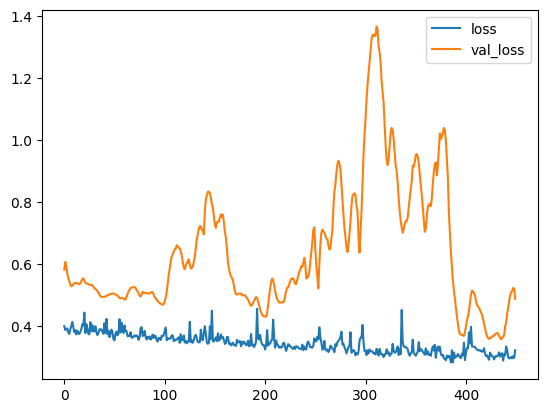

In [29]:
loss_df = pd.DataFrame(model.history.history)
loss_df[['loss', 'val_loss']].plot()

Training accuracy:

<Axes: >

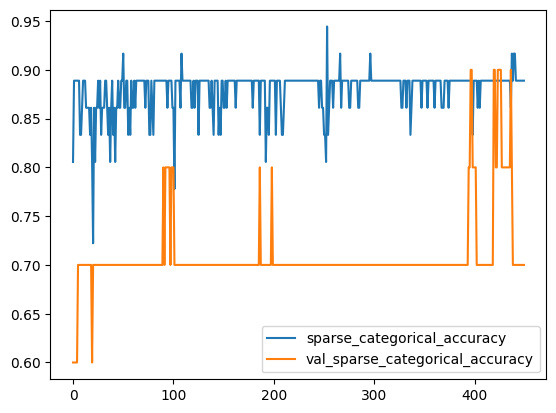

In [30]:
loss_df[['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot()

Train and test data evaluation:

In [31]:
model = keras.models.load_model("best_model2.keras")

print("Test data evaluation:")
print(model.evaluate(x_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(x_train, y_train, verbose=0))

Test data evaluation:
[0.3736652433872223, 0.75]

Train data evaluation:
[0.37384647130966187, 0.8913043737411499]


## Step 7: Prediction and metrics
Now I predict the values using the model, then we can see how the accurate it is.

In [32]:
test_predictions = model.predict(x_test)
test_predictions = np.argmax(test_predictions, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Confusion matrix:

Text(0.5, 1.0, 'Confusion Matrix')

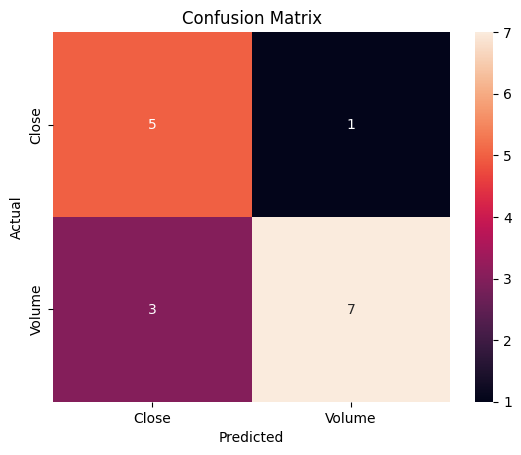

In [33]:
import seaborn as sns
cm = confusion_matrix(y_test, test_predictions)
ax = sns.heatmap(cm, annot=True, fmt='g', xticklabels=class_names, yticklabels=class_names)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')

Let's check the classification report and the overall accuracy:

In [34]:
print(classification_report(y_test, test_predictions, target_names=class_names))

acc = accuracy_score(y_test, test_predictions)
print("\nModel overall accuracy: {:.2f}%".format(acc * 100))

              precision    recall  f1-score   support

       Close       0.62      0.83      0.71         6
      Volume       0.88      0.70      0.78        10

    accuracy                           0.75        16
   macro avg       0.75      0.77      0.75        16
weighted avg       0.78      0.75      0.75        16


Model overall accuracy: 75.00%


### ROC-AUC score
To see the ROC-AUC score I have to reshape my data.

In [35]:
X_reshaped = X.reshape((X.shape[0], X.shape[1], 1))

probs = model.predict(X_reshaped)

roc = roc_auc_score(y, probs[:, 1])
print("ROC AUC (ovr):", roc)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
ROC AUC (ovr): 0.9531737773152966


As we can see, my model can accurately predict if its "Value" most of the time, however in some cases, it mispredicted "Close" values more times. We got the overall accuracy at 75%.

## Step 8: Imaginary generated signals.
I generate some imaginary data to test the model.


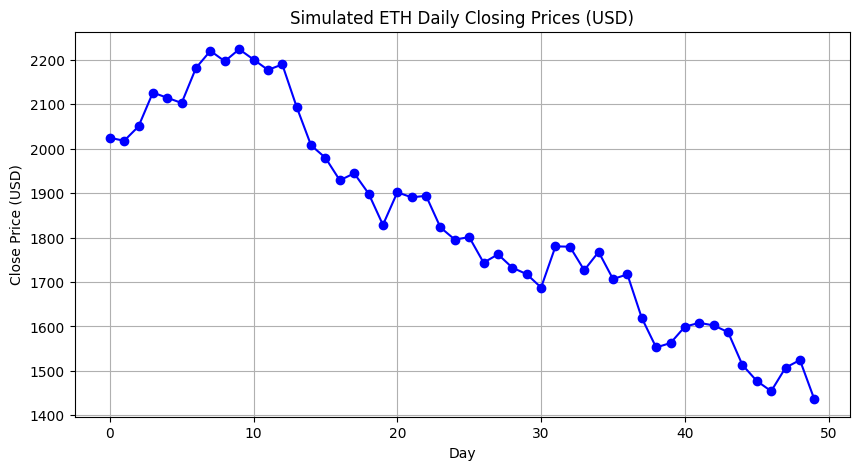

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(50)  # 0 to 49

np.random.seed(42)  # for reproducibility
daily_changes = np.random.normal(loc=0, scale=50, size=50)  
y = 2000 + np.cumsum(daily_changes) 

eth_data = y.reshape(-1, 1)

plt.figure(figsize=(10, 5))
plt.plot(x, eth_data, marker='o', linestyle='-', color='blue')
plt.title("Simulated ETH Daily Closing Prices (USD)")
plt.xlabel("Day")
plt.ylabel("Close Price (USD)")
plt.grid(True)
plt.show()


In [37]:
points = y
test_signal = np.expand_dims(points, axis=1)
test_batch = np.array([test_signal])

test_predict = model.predict(test_batch)
print(test_predict)

index = np.argmax(test_predict)
print(class_names[index])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
[[1. 0.]]
Close


# Step 9: Conclusion
I created a time series classification model that can classifie different patterns, the code successfully handled data processing and model training, it gave results that showed which signals belonged to each class. My accuracy was good after all (75%).
The approach worked well, however some parts, like optimizing the model took time. Performance could probably be improved with more data or trying more deep learning methods. Overall I'm satisfied with the results, which were consistent and showed that the method is effective.